In [37]:
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import norm
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression as LR
import matplotlib.pyplot as plt

In [30]:
def fileProcessor(F, featName, trainingSize):
    x_train = []   #Training Data
    x_test = []    #Testing Data 
    y_train = []   #Training Classifiers
    y_test = []    #Testing Classifiers
    file1 = True
    for file in F:    #F is a vector of file names
        x = []
        y = []
#         print(file)
        tree = ET.parse(file) #Create XML file tree
        root = tree.getroot() #Get root of tree... In our case root is 'feature_vector_file'
        for child in root:    #Loop through subelements of root
#             count = 0
            xx = []
            if child.tag == 'data_set':      #if subelement is 'data_set', perform:
                fileID = child.find('data_set_id').text   #'data_set_id' contains the classifer (i.e the composer name)
                composerName = fileID.split('/')[-2]      #extract composer name from 'data_set_id'
                composerID = 0
                if composerName == 'Beethoven':
#                     y.append(0)
                    composerID = 0
                elif composerName == 'Schubert':
#                     y.append(1)
                    composerID = 1
                elif composerName == 'Mozart':
#                     y.append(2)
                    composerID = 2
                else:
#                     y.append(3)
                    composerID = 3
                first = True
                for section in child.iter('section'):  #Loop through 'data_set' subelement for features
                    xx = []
#                     print(count)
                    if first == False:
#                         print('here')
                        y.append(composerID)
                        for feature in section.iter('feature'):
#                             print('here before 2')
                            if feature.find('name').text in featName:#['Power Spectrum Overall Average', 'Spectral Flux Overall Average', 'Beat Histogram Overall Average', 'MFCC Overall Average']:
#                                 print('here 2')
                                v = []                                #create empty array to contain feature values
                                vals = feature.findall('v')           #extract values of feature
                                for i in vals:                    #loop through extracted values
                                    if math.isnan(float(i.text)):
                                        print('found nan')
                                    v.append(i.text)                  #append text of values to values array
                                v = np.array(v).astype(np.float)
                                v = v.reshape(1, -1)
                                v = v.T
                                if len(xx) == 0:
#                                     print('if 1 ')
                                    xx = v
#                                     print(xx)
                                else:
#                                     print('else 1')
                                    if len(featName) == 1:
#                                         print('if 2')
                                        xx = np.c_[x, v]
#                                         print(xx)
                                    else:
#                                         print('else 2')
                                        xx = np.r_[xx, v]
#                                         print(xx)
                        if len(x) == 0:
#                             print('if 3')
                            x = xx
#                             print(x)
                        else:
#                             print('else 3')
#                             print(x)
#                             print(xx)
                            x = np.c_[x, xx]
#                             print(x)
                    first = False
#                     count = count + 1
        y = np.array(y)
        x_trainC, x_testC, y_trainC, y_testC = train_test_split(x.T, y, test_size=trainingSize)
        if file1 == True:
            x_train = x_trainC.T
            x_test = x_testC.T
            y_train = y_trainC
            y_test = y_testC
            file1 = False
        else:
            x_train = np.c_[x_train, x_trainC.T]    
            x_test = np.c_[x_test, x_testC.T]  
            y_train = np.concatenate((y_train, y_trainC))
            y_test = np.concatenate((y_test, y_testC)) 
    
    scaleX = StandardScaler()
    x_train = scaleX.fit_transform(x_train.T)
    x_test = scaleX.transform(x_test.T)
    
    return(x_train, x_test, y_train, y_test)

In [39]:
def LogisticRegression(data, alpha):
    #init
    x_train = data[0]
    x_test = data[1]
    y_train = data[2]
    y_test = data[3]
    learningRate = 0.1
    iter_n = 100

    #fit
    x_train = np.insert(x_train, 0, 1, axis=1)
    weights = []
    m = x_train.shape[0]
    for i in np.unique(y_train):
        y_copy = np.where(y_train == i, 1, 0)
        w = np.ones(x_train.shape[1])
        for _ in range(iter_n):
            output = x_train.dot(w)
            errors = y_copy - 1 / (1 + np.exp(-output))
            w += alpha / m * errors.dot(x_train)
        weights.append((w, i))

    pred = [max((i.dot(w), c) for w, c in weights)[1] for i in np.insert(x_test, 0, 1, axis=1)]
    return(y_test, pred)

In [32]:
def NaiveBayes(data):
    x_train = data[0]
    x_test = data[1]
    y_train = data[2]
    y_test = data[3]
    
    epsilon = (1e-9)*np.var(x_train, axis=0).max()
    
    featureLength = x_train.shape[1]
    composerSize = len(np.unique(y_train))
    mean = np.zeros((composerSize, featureLength))
    var = np.zeros((composerSize, featureLength))
    
    composer_count = np.zeros(composerSize, dtype=np.float64)
    composer_prior = np.zeros(len(np.unique(y_train)),dtype=np.float64)
    
    composers = np.unique(y_train)
    
    for y_i in composers:
        i = np.searchsorted(composers, y_i)
        composerData = x_train[y_train == y_i, :]

        N_i = composerData.shape[0]

        new_var = np.var(composerData, axis=0)
        new_mean = np.mean(composerData, axis=0)
        
        mean[i, :] = new_mean
        var[i, :] = new_var
        composer_count[i] += N_i
        
    var[:, :] += epsilon
    
    composer_prior = composer_count/sum(composer_count)
    
    likelihood = []
    for i in range(np.size(composers)):
        joint = np.log(composer_prior[i])
        nij = - 0.5 * np.sum(np.log(2. * np.pi * var[i, :]))
        nij -= 0.5 * np.sum(((x_test - mean[i, :]) ** 2) /
                             (var[i, :]), 1)
        likelihood.append(joint + nij)

    likelihood = np.array(likelihood).T
    y_pred = composers[np.argmax(likelihood, axis=1)].T
    
    
    return(y_test, y_pred)

In [33]:
def plot(data):
    y_test = data[0]
    y_pred = data[1]
    
    cm = confusion_matrix(y_test, y_pred)
#     print(cm)
#     print(accuracy_score(y_test, y_pred, normalize=True)*100)
    return(cm, accuracy_score(y_test, y_pred, normalize=True)*100)

In [34]:
def printM(matrix):
    targets = ['Beethoven', 'Schubert', 'Mozart', 'Chopin']
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Pastel1)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(targets))
    plt.xticks(tick_marks, targets, rotation=90)
    plt.yticks(tick_marks, targets)
    plt.tight_layout()
    width, height = matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(matrix[x][y]), xy=(y,x),
                        horizontalalignment = 'center',
                        verticalalignment= 'center')
    plt.ylabel('Prediction')
    plt.xlabel('Actual')
    plt.show()

Method of Moments
Naive Bayes


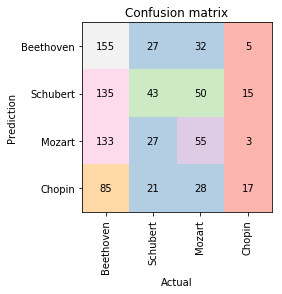

Accuracy = 32.49097472924188

Logistic Regression


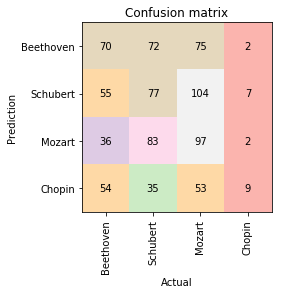

Accuracy = 30.445246690734056


MFCC
Naive Bayes


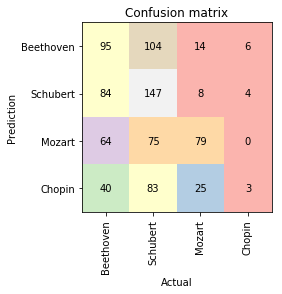

Accuracy = 38.98916967509025

Logistic Regression


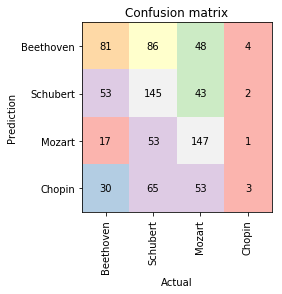

Accuracy = 45.246690734055356


LPC
Naive Bayes


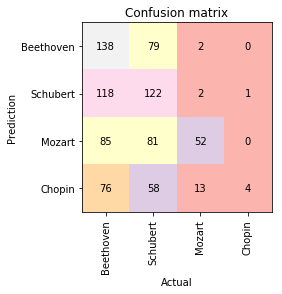

Accuracy = 38.02647412755716

Logistic Regression


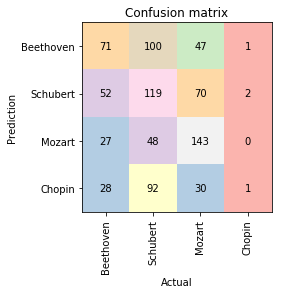

Accuracy = 40.19253910950662


All Features
Naive Bayes


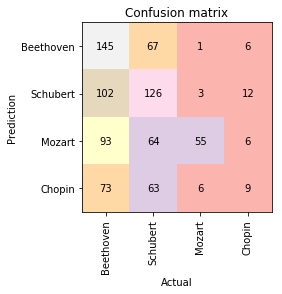

Accuracy = 40.312876052948255
Logistic Regression


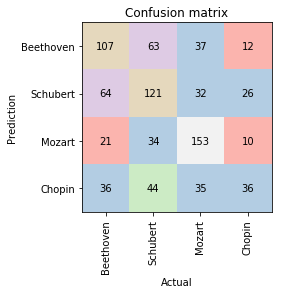

Accuracy = 50.18050541516246



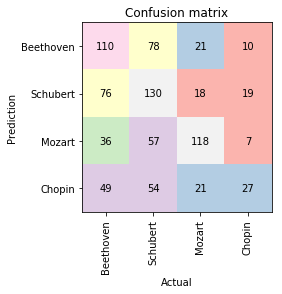

Accuracy = 46.32972322503009



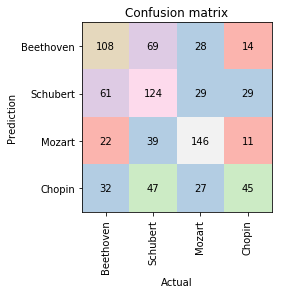

Accuracy = 50.90252707581227



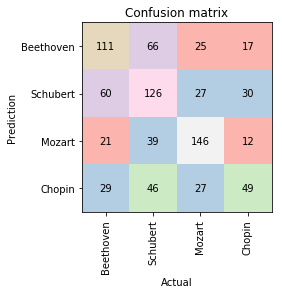

Accuracy = 51.985559566786996



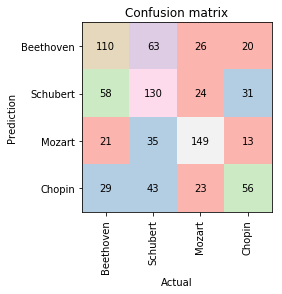

Accuracy = 53.549939831528285



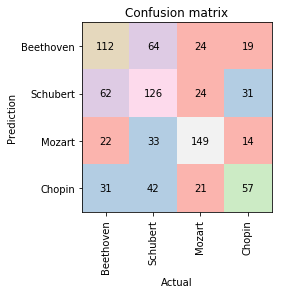

Accuracy = 53.42960288808665


Sklearn LR
[[113  62  24  20]
 [ 64 124  23  32]
 [ 20  33 151  14]
 [ 29  43  22  57]]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


53.549939831528285

In [53]:
v = ['beethovenValues.xml', 'schubertValues.xml', 'mozartValues.xml', 'chopinValues.xml']
# features = ['Spectral Flux', 'Compactness', 'Spectral Variability', 'Root Mean Square', 'Zero Crossings', 'Strongest Frequency Via Zero Crossings', 'Strongest Frequency Via Spectral Centroid', 'Strongest Frequency Via FFT Maximum', 'MFCC', 'LPC', 'Method of Moments', 'Peak Based Spectral Smoothness', 'Relative Difference Function']
features = ['Method of Moments', 'MFCC', 'LPC']

for i in range(len(features)):
    print(features[i])
    d = fileProcessor(v, [features[i]], 0.33)
    print('Naive Bayes')
    n = NaiveBayes(d)
    printM(plot(n)[0])
    print('Accuracy = '+str(plot(n)[1]))
    print('')
    print('Logistic Regression')
    l = LogisticRegression(d, 0.1)
    printM(plot(l)[0])
    print('Accuracy = '+str(plot(l)[1]))
    print('')
    print('')
print('All Features')
d = fileProcessor(v, features, 0.33)
print('Naive Bayes')
n = NaiveBayes(d)
printM(plot(n)[0])
print('Accuracy = '+str(plot(n)[1]))
print('Logistic Regression')
l = LogisticRegression(d, 0.1)
l2 = LogisticRegression(d, 0.01)
l3 = LogisticRegression(d, 0.3)
l4 = LogisticRegression(d, 0.5)
l5 = LogisticRegression(d, 1)
l6 = LogisticRegression(d, 2)
printM(plot(l)[0])
print('Accuracy = '+str(plot(l)[1]))
print('')
printM(plot(l2)[0])
print('Accuracy = '+str(plot(l2)[1]))
print('')
printM(plot(l3)[0])
print('Accuracy = '+str(plot(l3)[1]))
print('')
printM(plot(l4)[0])
print('Accuracy = '+str(plot(l4)[1]))
print('')
printM(plot(l5)[0])
print('Accuracy = '+str(plot(l5)[1]))
print('')
printM(plot(l6)[0])
print('Accuracy = '+str(plot(l6)[1]))
print('')
# print(d[0])

print('')
print('Sklearn LR')
naive = LR()
check = naive.fit(d[0], d[2]).predict(d[1])
cm = confusion_matrix(d[3], check)
print(cm)
accuracy_score(d[3], check, normalize=True)*100
# nm = 1000
# print('Performing Methods Over '+str(nm)+' Iterations')
# for i in range(len(features)):
#     print(features[i])
#     sumN = 0
#     sumL = 0
#     for j in range(nm):
#         d1 = fileProcessor(v, [features[i]], 0.33)
#         n1 = NaiveBayes(d1)
#         sumN = sumN + plot(n1)[1]
#         l1 = LogisticRegression(d1)
#         sumL = sumL + plot(l1)[1]
#     print('Naive Bayes Accuracy')
#     print(sumN/nm)
#     print('')
#     print('Logistic Regression Accuracy')
#     print(sumL/nm)
#     print('')
    
    
# print('Over All Features')
# sumN = 0
# sumL = 0
# for k in range(nm):
#     dj = fileProcessor(v, features, 0.33)
#     nj = NaiveBayes(dj)
#     sumN = sumN + plot(nj)[1]
#     lj = LogisticRegression(dj)
#     sumL = sumL + plot(lj)[1]
# print('Naive Bayes Accuracy')
# print(sumN/nm)
# print('')
# print('Logistic Regression Accuracy')
# print(sumL/nm)
# print('')

In [45]:
[[159  50   4   6]
 [131  93   4  15]
 [129  31  53   5]
 [ 68  54   4  25]]


SyntaxError: invalid syntax (<ipython-input-45-f61d4dac1be2>, line 1)